In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style("whitegrid")
%matplotlib inline

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
regions = pd.read_csv("ETA_AB_Regions (1).csv")
ride = pd.read_csv("ETA_Ride (1).csv")
rps = pd.read_csv('ETA_RPS (1).csv')


In [43]:
###### read and aggregate rps data
rps = rps.groupby(['rideId'], as_index = False).agg({'rankTime': 'max', 'isAccept': 'sum'})
rps.columns = ['rideId', 'numDrivers', 'driversAccept']

In [44]:
####### merge ride data with regions
ride = ride.merge(regions, on = 'regionId', how = 'left')

In [45]:
df = rps.merge(ride, on = 'rideId', how = 'left')

##### convert id columns to str
df['rideId'] = df['rideId'].astype(str)
df['regionId'] = df['regionId'].astype(str)

####### convert date and compute hour of day
df['createdAt'] = pd.to_datetime(df['createdAt'], format = "%Y-%m-%d")
df['hour'] = df['createdAt'].dt.hour


In [46]:
df.head()

,rideId,numDrivers,driversAccept,createdAt,isAssigned,price,regionId,isTreatment,hour
0,4,1,0,2020-10-04 07:43:56.560000+03:30,0.0,88000.0,770,0,7
1,6,1,1,2020-10-04 07:54:09.933000+03:30,1.0,89000.0,770,0,7
2,8,1,0,2020-10-04 07:41:12.633000+03:30,0.0,88000.0,770,0,7
3,10,3,0,2020-10-04 11:10:04.083000+03:30,0.0,6500.0,771,0,11
4,11,1,0,2020-10-04 16:14:22.557000+03:30,0.0,63000.0,771,0,16


In [47]:
df.isna().sum()

rideId           0
numDrivers       0
driversAccept    0
createdAt        0
isAssigned       0
price            0
regionId         0
isTreatment      0
hour             0
dtype: int64

## 1) Visualization

Prob
isTreatment isAssigned          
0           1.0         0.647562
            0.0         0.352438
1           1.0         0.659974
            0.0         0.340026

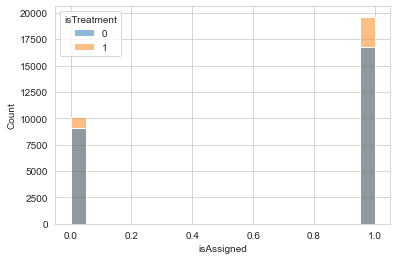

In [48]:
#####
sns.histplot(data = df, x = 'isAssigned', hue = 'isTreatment')
pd.DataFrame(df.groupby(['isTreatment'])['isAssigned'].value_counts(normalize = True))\
                .rename(columns = {'isAssigned': 'Prob'})

Basic Statistics for number of drivers acceptance per Ride: 


isTreatment,0,1
count,25823.000000,29733.000000
mean,0.821709,0.824572
std,0.700287,0.678735
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,6.000000,5.000000


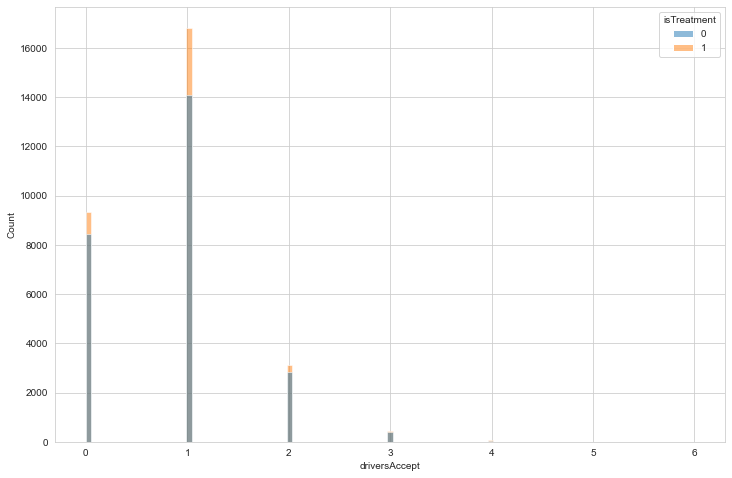

In [49]:
plt.figure(figsize = (12,8))
sns.histplot(data = df, x = 'driversAccept', hue = 'isTreatment')
print('Basic Statistics for number of drivers acceptance per Ride: ')
df.groupby(['isTreatment'])['driversAccept'].describe().T

count          mean           std     min      25%  \
isTreatment isAssigned                                                         
0           0.0          9101.0  23908.856170  12268.592736  5000.0  15500.0   
            1.0         16722.0  25243.003229  13033.508145  5000.0  16500.0   
1           0.0         10110.0  22442.977250  11898.083284  5000.0  13500.0   
            1.0         19623.0  23891.581308  12469.226393  5000.0  15000.0   

                            50%      75%       max  
isTreatment isAssigned                              
0           0.0         22500.0  29500.0  111000.0  
            1.0         22500.0  31000.0  192000.0  
1           0.0         20500.0  28500.0  110000.0  
            1.0         21500.0  30000.0  155000.0

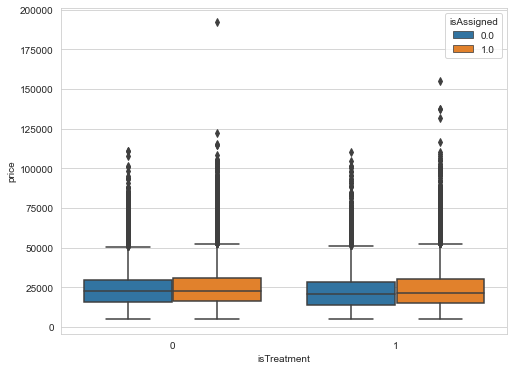

In [50]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'isTreatment', y = 'price', hue = 'isAssigned', data = df)
df.groupby(['isTreatment', 'isAssigned'])['price'].describe()


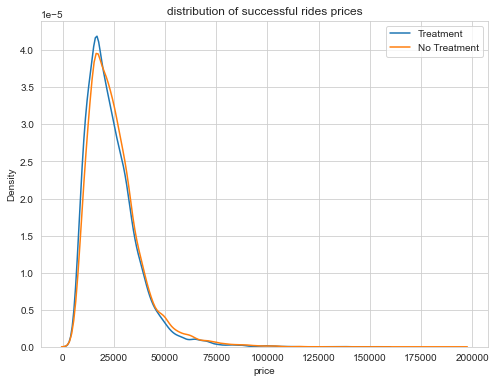

In [51]:
plt.figure(figsize = (8,6))
sns.kdeplot(df[(df['isAssigned'] == 1) & (df['isTreatment'] == 1)]['price'], label = 'Treatment')
sns.kdeplot(df[(df['isAssigned'] == 1) & (df['isTreatment'] == 0)]['price'], label = 'No Treatment')
plt.title("distribution of successful rides prices")
plt.legend()

In [52]:
rides_per_hour = df.groupby(['isTreatment', 'hour'], as_index = False).agg({'isAssigned': 'sum', 'rideId': pd.Series.nunique})
rides_per_hour.rename(columns = {'isAssigned': 'successRides', 'rideId': 'TotalRides'}, inplace = True)
rides_per_hour['successRate'] = rides_per_hour['successRides'] / rides_per_hour['TotalRides']

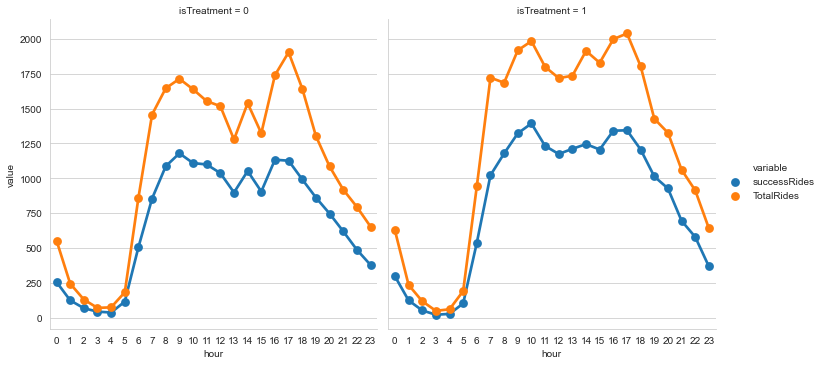

In [53]:
sns.catplot(data = pd.melt(rides_per_hour, id_vars = ['isTreatment', 'hour'], value_vars = ['successRides', 'TotalRides']),
           x = 'hour', y = 'value', col='isTreatment', hue = 'variable', kind = 'point')

Text(0, 0.5, 'rate')

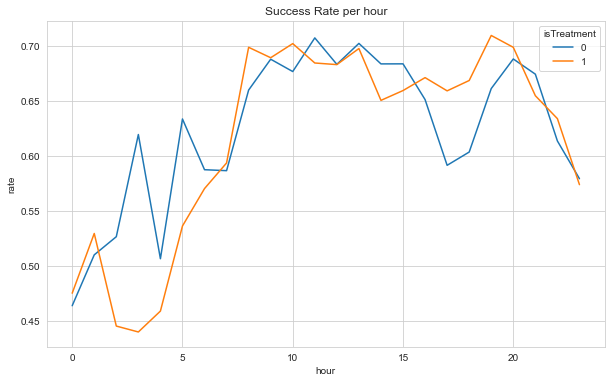

In [54]:
plt.figure(figsize = (10,6))
sns.lineplot('hour', 'successRate', hue = 'isTreatment', data = rides_per_hour)
plt.title("Success Rate per hour")
plt.ylabel("rate")

In [55]:
income = df[['hour', 'isTreatment', 'isAssigned', 'price']].copy()
income = income.groupby(['hour', 'isTreatment','isAssigned'], as_index = False).agg({'price': 'sum'})

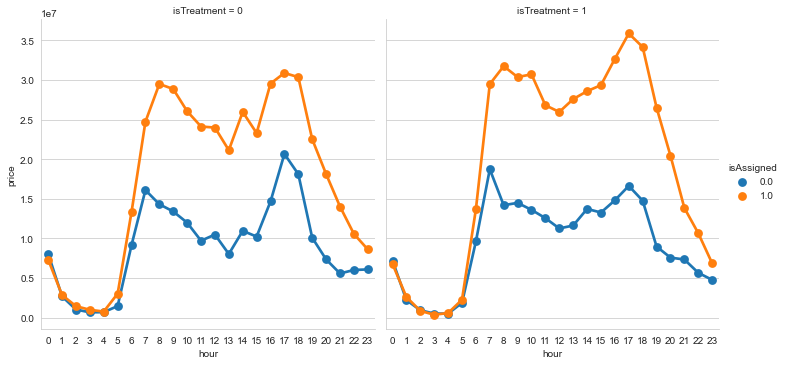

In [56]:
###### sum of prices per hour for each treatment group and assignments
sns.catplot(data = income, x = 'hour', y = 'price', col='isTreatment', hue = 'isAssigned', kind = 'point')

In [57]:
income['income'] = income['isAssigned'] * income['price']
income_per_hour = income.groupby(['hour', 'isTreatment'], as_index = False).agg({'price': 'sum', 'income': 'sum'})
income_per_hour['incomeToprice'] = income_per_hour['income'] / income_per_hour['price']

In [58]:
income_per_hour.tail()

,hour,isTreatment,price,income,incomeToprice
43,21,1,21187000.0,13845000.0,0.653467
44,22,0,16590000.0,10572000.0,0.637251
45,22,1,16324000.0,10660000.0,0.653026
46,23,0,14700500.0,8611500.0,0.585796
47,23,1,11626500.0,6859500.0,0.589988


in table income_per_hour, we have two columns:

1) price is sum of price of all rides within each treatment group per hour.

2) income is sum of prices of successful rides.

Text(0.5, 1.0, 'share of successful rides from total ride prices')

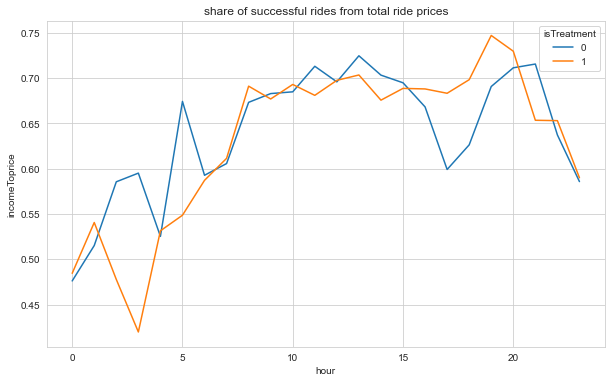

In [59]:
plt.figure(figsize = (10,6))
sns.lineplot(x = 'hour', y = 'incomeToprice', hue = 'isTreatment', data = income_per_hour)
plt.title("share of successful rides from total ride prices")

# 2) Analyzing A/B test results

### 2-1) Hypothesis testing for isAssigned variable

#### 2-1-1) Statistical test

is Assigned variable is a binary variable which shows success or failure in assigning a ride to a driver. we want to compare probability of sucess in two samples (treatment and control), statistical test for this aim is proprortion Z-test

suppose m1 is expected value of control group and m2 is expected value of treatment group.(from expected value I mean proportion of success in trials which in our case in proportion of assigned rides), hypothesis test is:


H0: m2 <= m1 (proportion of treatment group is equal or less than treatment group)

H1: m2 > m1 (proportion of treatment group is larger than treatment group)

I will consider significance level of 0.1

In [60]:
df.groupby(['isTreatment'])['isAssigned'].mean()

isTreatment
0    0.647562
1    0.659974
Name: isAssigned, dtype: float64

In [61]:
from statsmodels.stats.proportion import proportions_ztest

In [62]:
n_treatment = df[(df['isTreatment'] == 1)]['rideId'].nunique()
n_treatment_success = df[(df['isTreatment'] == 1) & (df['isAssigned'] == 1)]['rideId'].nunique()

n_control = df[(df['isTreatment'] == 0)]['rideId'].nunique()
n_control_success = df[(df['isTreatment'] == 0) & (df['isAssigned'] == 1)]['rideId'].nunique()

In [63]:
z_test, p_value = proportions_ztest(count=[n_treatment_success, n_control_success], nobs=[n_treatment, n_control], alternative='larger')
print("P-Value for Z-proportion test is: ", p_value)

P-Value for Z-proportion test is:  0.0010784935583003042


P-value of our test is less than significance level, thus H0 is rejected. so we can say that increase in proportion of sucess for treatment group is statistically significant.

#### 2-1-2) Regression approcah

The goal in this part is to use statsmodels to fit the regression model, to see if there is a significant difference in ride assignment based on which algorithm the ride belongs to. First we need to create a column for the intercept.

In [64]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [65]:
assignment = df[['isTreatment', 'isAssigned']].copy()
assignment.sort_values('isTreatment', ascending = False, inplace = True)
assignment['intercept'] = 1

In [66]:
assignment

,isTreatment,isAssigned,intercept
27778,1,0.0,1
31429,1,1.0,1
31422,1,1.0,1
31423,1,1.0,1
31424,1,1.0,1
...,...,...,...
17257,0,1.0,1
17256,0,1.0,1
17255,0,1.0,1
17254,0,0.0,1


In [67]:
logit_mod = sm.Logit(assignment['isAssigned'], assignment[['intercept', 'isTreatment']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.644720
         Iterations 4


In [68]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             isAssigned   No. Observations:                55556
Model:                          Logit   Df Residuals:                    55554
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:               0.0001313
Time:                        20:23:27   Log-Likelihood:                -35818.
converged:                       True   LL-Null:                       -35823.
Covariance Type:            nonrobust   LLR p-value:                  0.002161
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.6083      0.013     46.702      0.000       0.583       0.634
isTreatment     0.0548      0.018      3.068      0.002       0.020       0.090
===============================================================================
"""

The p-value calculated here is 0.002. This is because the Logit Regression is based on a two-tailed test. 0.002 is still less then 0.1 (our $\alpha$), so we still can reject our null hypothesis. It means that "isTreatment" has statistically significant effect on "Assignment". coef for isTreatment is 0.0548 which means treatmeant group on average has 0.054 higher assignment probability.

## 2-2) Hypothesis testing for driver acceptance rate

in this part as requested in task, I will create another variable for each ride: dividing "numDrivers" by "driversAccept". this variable shows driver acceptance rate for each ride. then I will perform statistical analysis to check differences of accpetance rate between two groups (treatment and contol)

In [69]:
df['DriverAcceptanceRate'] = df['driversAccept'] / df['numDrivers']
df.head()

,rideId,numDrivers,driversAccept,createdAt,isAssigned,price,regionId,isTreatment,hour,DriverAcceptanceRate
0,4,1,0,2020-10-04 07:43:56.560000+03:30,0.0,88000.0,770,0,7,0.0
1,6,1,1,2020-10-04 07:54:09.933000+03:30,1.0,89000.0,770,0,7,1.0
2,8,1,0,2020-10-04 07:41:12.633000+03:30,0.0,88000.0,770,0,7,0.0
3,10,3,0,2020-10-04 11:10:04.083000+03:30,0.0,6500.0,771,0,11,0.0
4,11,1,0,2020-10-04 16:14:22.557000+03:30,0.0,63000.0,771,0,16,0.0


,count,mean,std,min,25%,50%,75%,max
isTreatment,,,,,,,,
0,25823.0,0.521751,0.446292,0.0,0.0,0.5,1.0,1.0
1,29733.0,0.522970,0.442717,0.0,0.0,0.5,1.0,1.0


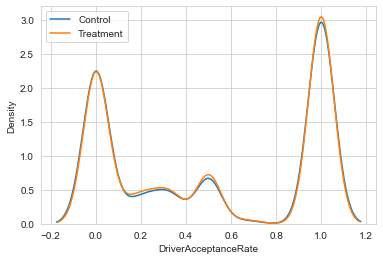

In [70]:
sns.kdeplot(df[df['isTreatment'] == 0]['DriverAcceptanceRate'], label = 'Control')
sns.kdeplot(df[df['isTreatment'] == 1]['DriverAcceptanceRate'], label = 'Treatment')
plt.legend()

df.groupby(['isTreatment'])['DriverAcceptanceRate'].describe()

<AxesSubplot:xlabel='hour', ylabel='DriverAcceptanceRate'>

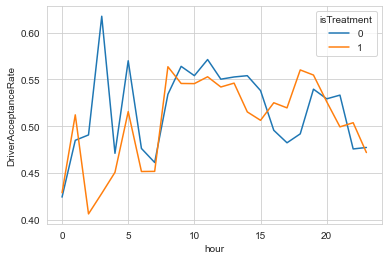

In [71]:
sns.lineplot(x = 'hour', y = 'DriverAcceptanceRate',hue = 'isTreatment',
             data = df.groupby(['isTreatment', 'hour'], as_index = False).agg({'DriverAcceptanceRate':'mean'}))

in plot above we see that in different hours of day, mean of driver acceptance rate has been changed with time. for example between 10 to 15 control group has higher acceptance rate but from 15 to 20 treatment group average acceptance rate is higher. this may show that performance of algorithms may varry across hour. I will consider effect of time for acceptance rate.

### 2-2-1) Regression analysis of "Driver Accpetance Rate"

as "Driver Acceptance Rate" is a continious variable, I will use OLS regression.

In [72]:
driver_accept = df[['isTreatment', 'DriverAcceptanceRate']].copy()
driver_accept['intercept'] = 1

In [73]:
lr_model = sm.OLS(driver_accept['DriverAcceptanceRate'], driver_accept[['isTreatment', 'intercept']])
results = lr_model.fit()

In [74]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     DriverAcceptanceRate   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.000
Method:                   Least Squares   F-statistic:                    0.1040
Date:                  Wed, 03 Feb 2021   Prob (F-statistic):              0.747
Time:                          20:23:54   Log-Likelihood:                -33770.
No. Observations:                 55556   AIC:                         6.754e+04
Df Residuals:                     55554   BIC:                         6.756e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
isTreatment     0.0012      0.004      0.323      0.747      -0.006       0.009
intercept       0.5218      0.003    188.673      0.000       0.516       0.527
==============================================================================
Omnibus:                   220696.818   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7349.405
Skew:                          -0.023   Prob(JB):                         0.00
Kurtosis:                       1.219   Cond. No.                         2.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

from results above we could see that on average acceptance rate is 0.0012 higher in treatment group but The p-value calculated here is 0.747 which is much greater than 0.1 (our $\alpha$), so we can not reject our null hypothesis. It means that "isTreatment" has no statistically significant effect on "Driver Acceptance Rate".

In [36]:
driver_accept = df[['isTreatment', 'DriverAcceptanceRate']].copy()
driver_accept['intercept'] = 1
driver_accept['hour'] = df['hour'].copy()
driver_accept = pd.concat([driver_accept, pd.get_dummies(driver_accept['hour'], prefix='hour')], axis = 1)

In [37]:
for i in range(0,24):
    driver_accept[f'treatment_hour_{i}'] = driver_accept['isTreatment'] * driver_accept[f'hour_{i}']
    #driver_accept.drop(columns = [f'hour_{i}'], inplace = True)

In [38]:
lr_model = sm.OLS(driver_accept['DriverAcceptanceRate'], driver_accept.drop(columns = ['DriverAcceptanceRate','hour']))
results = lr_model.fit()

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     DriverAcceptanceRate   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     7.906
Date:                  Wed, 03 Feb 2021   Prob (F-statistic):           7.88e-52
Time:                          20:07:21   Log-Likelihood:                -33584.
No. Observations:                 55556   AIC:                         6.726e+04
Df Residuals:                     55508   BIC:                         6.769e+04
Df Model:                            47                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
isTreatment          -0.0126      0.006     -1.981      0.048      -0.025      -0.000
intercept             0.4976      0.004    113.836      0.000       0.489       0.506
hour_0               -0.0732      0.019     -3.940      0.000      -0.110      -0.037
hour_1               -0.0126      0.028     -0.457      0.648      -0.066       0.041
hour_2               -0.0068      0.037     -0.183      0.855      -0.080       0.066
hour_3                0.1198      0.051      2.367      0.018       0.021       0.219
hour_4               -0.0264      0.049     -0.537      0.591      -0.123       0.070
hour_5                0.0723      0.032      2.279      0.023       0.010       0.134
hour_6               -0.0213      0.015     -1.407      0.160      -0.051       0.008
hour_7               -0.0362      0.012     -3.030      0.002      -0.060      -0.013
hour_8                0.0365      0.011      3.219      0.001       0.014       0.059
hour_9                0.0663      0.011      5.944      0.000       0.044       0.088
hour_10               0.0564      0.011      4.959      0.000       0.034       0.079
hour_11               0.0736      0.012      6.326      0.000       0.051       0.096
hour_12               0.0526      0.012      4.479      0.000       0.030       0.076
hour_13               0.0550      0.013      4.343      0.000       0.030       0.080
hour_14               0.0564      0.012      4.826      0.000       0.033       0.079
hour_15               0.0405      0.012      3.245      0.001       0.016       0.065
hour_16              -0.0019      0.011     -0.169      0.866      -0.024       0.020
hour_17              -0.0152      0.011     -1.424      0.154      -0.036       0.006
hour_18              -0.0057      0.011     -0.501      0.617      -0.028       0.017
hour_19               0.0420      0.013      3.343      0.001       0.017       0.067
hour_20               0.0317      0.014      2.326      0.020       0.005       0.058
hour_21               0.0356      0.015      2.427      0.015       0.007       0.064
hour_22              -0.0218      0.016     -1.388      0.165      -0.053       0.009
hour_23              -0.0202      0.017     -1.176      0.240      -0.054       0.013
treatment_hour_0      0.0173      0.026      0.675      0.500      -0.033       0.067
treatment_hour_1      0.0398      0.039      1.012      0.311      -0.037       0.117
treatment_hour_2     -0.0716      0.054     -1.322      0.186      -0.178       0.035
treatment_hour_3     -0.1764      0.079     -2.241      0.025      -0.331      -0.022
treatment_hour_4     -0.0077      0.074     -0.104      0.917      -0.152       0.136
treatment_hour_5     -0.0416      0.044     -0.938      0.348      -0.129       0.045
treatment_hour_6     -0.0120      0.021     -0.569 

as we can see in results of second regression model in hours between 16 and 18, treatment causes higher driver acceptance rate, for example for hour 18:

coeffiecient of regression for "treatment_hour_18" is 0.0808 which means in hour 18, treatment group on average has 0.0808 higher acceptance rate and P-value for this coeff is 0.0 which is less than 0.1. so it means "treatment_hour_18" has significance effect on driver acceptance rate.

## 2-3) Price

### 2-3-1) statistical test

isTreatment,0,1
count,25823.000000,29733.000000
mean,24772.799442,23399.017926
std,12784.812003,12296.966803
min,5000.000000,5000.000000
25%,16000.000000,14500.000000
50%,22500.000000,21000.000000
75%,30500.000000,29500.000000
max,192000.000000,155000.000000


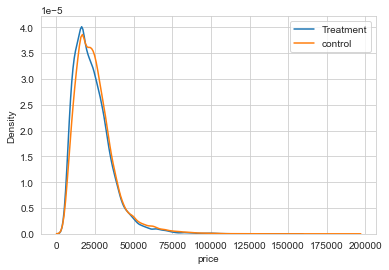

In [40]:
sns.distplot(df[(df['isTreatment'] == 1)]['price'], label = 'Treatment', hist = False)
sns.distplot(df[(df['isTreatment'] == 0)]['price'], label = 'control', hist = False)
plt.legend()

df.groupby(['isTreatment'])['price'].describe().T

I will perform T-test on price variable to check if difference in their mean in significant. mean of price in treatment group is 23399 which is lower than control group 24772. so our hypothesis test is:

H0: exp(price_treatment) >= exp(price_treatment)

H1: exp(price_treatment) < exp(price_treatment)

In [41]:
from scipy.stats import ttest_ind

In [42]:
ttest_ind(df[(df['isTreatment'] == 1)]['price'], df[(df['isTreatment'] == 0)]['price'])

Ttest_indResult(statistic=-12.89316498163016, pvalue=5.57650638580439e-38)

p-value of hypothesis test is very small (much less than 0.1), so H0 is rejected and we have enough evidence to say that difference in mean of prices is significant. 

In [43]:
print("difference in mean of prices: ", 24772.799442 - 23399.017926, '. Treatmeant group has lower mean')

difference in mean of prices:  1373.781515999999 . Treatmeant group has lower mean


#### compare quantiles of price

In [44]:
from scipy.stats.mstats import hdquantiles

price_quantiles = pd.DataFrame({'quantile': np.arange(0.1, 1, 0.1),
                               'treatment': hdquantiles(df[(df['isTreatment'] == 1)]['price'], prob = np.arange(0.1, 1, 0.1)),
                               'control': hdquantiles(df[(df['isTreatment'] == 0)]['price'], prob = np.arange(0.1, 1, 0.1))})

price_quantiles['difference'] = price_quantiles['treatment'] - price_quantiles['control']

In [45]:
price_quantiles

,quantile,treatment,control,difference
0,0.1,10499.418286,11500.200098,-1000.781811
1,0.2,13185.848670,14514.481811,-1328.633141
2,0.3,15999.598172,17001.751952,-1002.153780
3,0.4,18427.263923,19946.987901,-1519.723978
4,0.5,21080.334523,22519.012425,-1438.677902
5,0.6,24156.542169,25479.993097,-1323.450928
6,0.7,27513.843237,28550.392122,-1036.548885
7,0.8,31592.805949,32622.078694,-1029.272745
8,0.9,38180.713846,39451.176282,-1270.462435


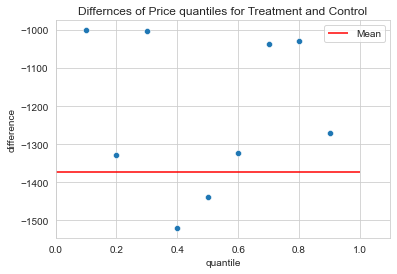

In [46]:
sns.scatterplot(x = 'quantile', y = 'difference', data = price_quantiles)
plt.hlines(y = -1373, xmin = 0, xmax=1.0, label = 'Mean', color = 'red')
plt.xlim(left = 0, right = 1.1)
plt.title("Differnces of Price quantiles for Treatment and Control")
plt.legend(loc = 1)

difference in quantiles (called shift function in statistics) shows that for all quantiles of price distributions, treatment group has lower price.

### 2-3-2) Regression analysis for price

In [47]:
price = df[['isTreatment', 'hour', 'price']].copy()
price['intercept'] = 1

In [48]:
lr_model = sm.OLS(price['price'], price[['isTreatment', 'intercept']])
results = lr_model.fit()

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     166.2
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           5.58e-38
Time:                        20:09:53   Log-Likelihood:            -6.0303e+05
No. Observations:               55556   AIC:                         1.206e+06
Df Residuals:                   55554   BIC:                         1.206e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
isTreatment -1373.7815    106.551    -12.893      0.000   -1582.622   -1164.941
intercept    2.477e+04     77.949    317.807      0.000    2.46e+04    2.49e+04
==============================================================================
Omnibus:                    20329.141   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103520.905
Skew:                           1.705   Prob(JB):                         0.00
Kurtosis:                       8.753   Cond. No.                         2.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

result of regression analysis is same as our T-test results and indicates that treatment group has lower price on average.

##### add variable hour for price analysis
result of regression analysis shows that on average treatment group price is 1373.78 less than control group and p-value of this coeff is 0.0 which means this coeff has significant impact on regression. for further analysis let's add hour parameter to our regression.

In [50]:
price = df[['isTreatment', 'hour', 'price']].copy()
price['intercept'] = 1
price = pd.concat([price, pd.get_dummies(price['hour'], prefix='hour')], axis = 1)

for i in range(0,24):
    price[f'treatment_hour_{i}'] = price['isTreatment'] * price[f'hour_{i}']

In [51]:
lr_model = sm.OLS(price['price'], price.drop(columns = ['price','hour']))
results = lr_model.fit()

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     51.82
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:10:16   Log-Likelihood:            -6.0192e+05
No. Observations:               55556   AIC:                         1.204e+06
Df Residuals:                   55508   BIC:                         1.204e+06
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
isTreatment       -1861.3023    176.676    -10.535      0.000   -2207.588   -1515.017
intercept           2.31e+04    121.170    190.606      0.000    2.29e+04    2.33e+04
hour_0             4717.5699    515.020      9.160      0.000    3708.128    5727.012
hour_1             -475.1988    762.405     -0.623      0.533   -1969.518    1019.120
hour_2            -4206.2940   1036.492     -4.058      0.000   -6237.825   -2174.763
hour_3              333.9705   1403.488      0.238      0.812   -2416.876    3084.817
hour_4            -3628.9403   1365.836     -2.657      0.008   -6305.988    -951.893
hour_5             1456.3056    879.328      1.656      0.098    -267.183    3179.794
hour_6             3035.6358    419.409      7.238      0.000    2213.592    3857.680
hour_7             4935.9647    331.594     14.886      0.000    4286.038    5585.891
hour_8             3538.7395    314.748     11.243      0.000    2921.832    4155.647
hour_9             1579.2325    309.381      5.104      0.000     972.844    2185.621
hour_10             135.1622    315.320      0.429      0.668    -482.868     753.192
hour_11           -1306.4892    322.591     -4.050      0.000   -1938.770    -674.208
hour_12            -365.2181    325.862     -1.121      0.262   -1003.911     273.474
hour_13            -269.7071    351.139     -0.768      0.442    -957.942     418.528
hour_14             915.7714    323.940      2.827      0.005     280.848    1550.695
hour_15            2249.8201    345.838      6.505      0.000    1571.975    2927.666
hour_16            2331.9376    307.417      7.586      0.000    1729.399    2934.476
hour_17            3996.3531    296.017     13.500      0.000    3416.159    4576.548
hour_18            6409.5665    314.911     20.354      0.000    5792.339    7026.794
hour_19            1933.5565    348.159      5.554      0.000    1251.163    2615.950
hour_20             391.9506    377.650      1.038      0.299    -348.245    1132.147
hour_21           -1768.6211    407.098     -4.344      0.000   -2566.536    -970.706
hour_22           -2227.6825    435.073     -5.120      0.000   -3080.428   -1374.937
hour_23            -617.7782    476.375     -1.297      0.195   -1551.476     315.919
treatment_hour_0  -3631.3004    709.343     -5.119      0.000   -5021.618   -2240.983
treatment_hour_1   -326.9025   1089.027     -0.300      0.764   -2461.403    1807.598
treatment_hour_2  -1964.9855   1502.443     -1.308      0.191   -4909.783     979.812
treatment_hour_3  -4038.2752   2182.327     -1.850      0.064   -8315.650     239.100
treatment_hour_4    361.8487   2039.030      0.177      0.859   -3634.665    4358.362
treatment_hour_5  -1180.1936   1229.930     -0.960      0.337   -3590.865    1230.478
treatment_hour_6    447.4509    582.785      0.768      0.443    -694.812

for example for hour 13, "treatment_hour_13" coeff is 1645 which means in this hour treatment group rides mean is 1645 higher than control group mean with p-value of 0.0 that shows high significance.

let's visualize distribution of prices for both groups per hour.

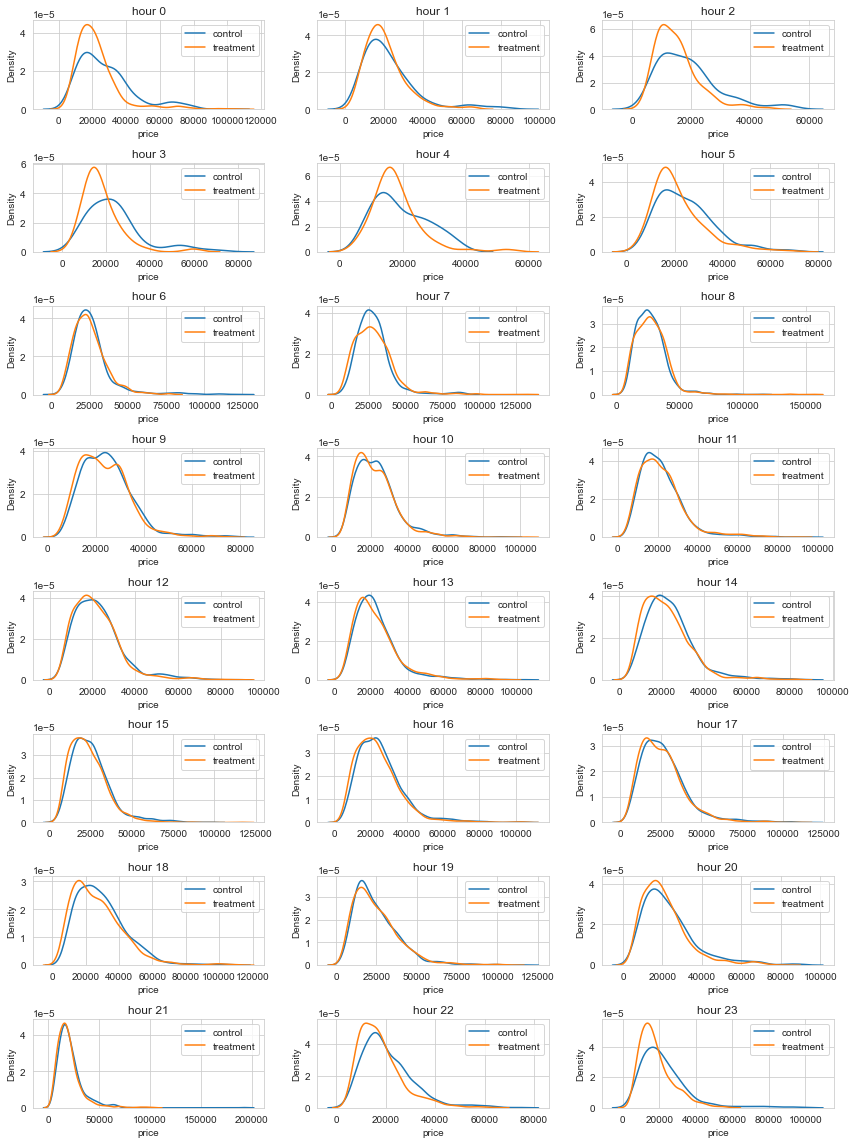

In [53]:
plt.figure(figsize = (12,16))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    sns.distplot(df[(df['hour'] == i) & (df['isTreatment'] == 0)]['price'], label = 'control', hist = False)
    sns.distplot(df[(df['hour'] == i) & (df['isTreatment'] == 1)]['price'], label = 'treatment', hist = False)
    plt.legend()

    plt.title(f'hour {i}')

plt.tight_layout()